In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# import requests 
# url="https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
# res=requests.get(url)
# words=(res.text).splitlines()
# print(len(words),max(len(w) for w in words),min(len(w) for w in words))

32033 15 2


In [5]:
import csv

# Open the file using the open() function
with open(r"D:\D\archive\users.csv" , 'r') as file:
  # Use the csv.reader() function to read the file
  reader = csv.reader(file)
  
  # Convert the reader object to a list
  data = list(reader)

KeyboardInterrupt: 

In [6]:
data

NameError: name 'data' is not defined

In [3]:
chars =sorted(list(set((''.join(words)))))
# map char to int 
stoi={s:i+1 for i, s in enumerate(chars)}
stoi["."]=0
# map int to char 
itos={i:s for s,i in stoi.items()}

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [6]:
for p in parameters:
  p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [7]:
for i in range(4000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (8000,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.01 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
  if i%50==0:

    print(loss)


tensor(25.9407, grad_fn=<NllLossBackward0>)
tensor(19.0153, grad_fn=<NllLossBackward0>)
tensor(16.7130, grad_fn=<NllLossBackward0>)
tensor(14.8406, grad_fn=<NllLossBackward0>)
tensor(13.3392, grad_fn=<NllLossBackward0>)
tensor(12.3874, grad_fn=<NllLossBackward0>)
tensor(11.8250, grad_fn=<NllLossBackward0>)
tensor(11.1897, grad_fn=<NllLossBackward0>)
tensor(10.7086, grad_fn=<NllLossBackward0>)
tensor(10.0806, grad_fn=<NllLossBackward0>)
tensor(9.9594, grad_fn=<NllLossBackward0>)
tensor(9.6582, grad_fn=<NllLossBackward0>)
tensor(9.2739, grad_fn=<NllLossBackward0>)


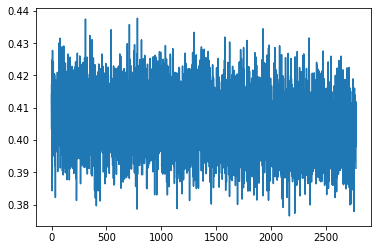

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5205, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 15) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2978, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3426, grad_fn=<NllLossBackward0>)

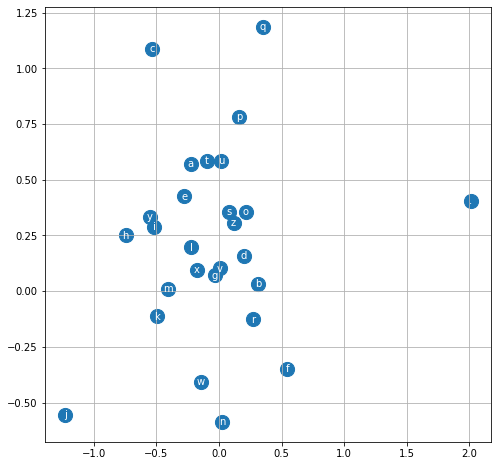

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpa.
fato.
lari.
kemili.
taty.
halaysa.
jazhutra.
mery.
calaeni.
ner.
kearce.
dir.
kaleigh.
ham.
jori.
quint.
shois.
aliva.
quis.
ero.
